<h1> RETAIL ANALYTICS WITH DEMAND FORECASTING AND INVENTORY MANAGEMENT </h1>

<div style="text-align: right"> <i>By: Krishna Kanjani</i> </div>

## INTRODUCTION

In the world of supply chain management, predicting what customers will want and how much they'll want of it is a big challenge. Traditionally, experts have relied on their intuition and basic statistics to guess future demand, especially for smaller product categories with consistent demand patterns.

But as businesses grow and deal with larger product ranges and unpredictable consumer trends, this old-school approach becomes less reliable. That's where our modern solution comes in – using data and computer programs to forecast demand more accurately and efficiently.

In this project, we're going to use Python to build a model that predicts how much of our top-selling product customers will buy in the next two years <i>(The data is of the years 2015 to 2018. But the data soes not have much information of the year 2018. So we will consider the data only till the year 2017 and make predictions for the years 2018 and 2019)</i>. Then, we'll use this prediction to figure out the best inventory levels for that product, including when to reorder and how much safety stock we need.

Throughout this project, we will address two key business questions:

- **What is the demand forecast for the top-selling product in the next 24 months?**
- **What is the optimal inventory level for the product?**

Join me on this journey as we dive into the demand forecasting and inventory optimization!

## ~ Importing Required Libraries ~

In [1]:
import pandas as pd
import numpy as np # For linear algebra
import math # For math operations 
from sklearn.preprocessing import LabelEncoder # For Data preprocessing
from prophet import Prophet # For Model Building and Fitting
# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

## ~ Exploratory Data Analysis ~

In [2]:
dataset = pd.read_csv("dataset.csv", encoding="ISO-8859-1")
dataset.head(5)

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [3]:
dataset["order date (DateOrders)"] = pd.to_datetime(dataset["order date (DateOrders)"])
dataset["shipping date (DateOrders)"] = pd.to_datetime(dataset["shipping date (DateOrders)"])

In [4]:
dataset = dataset[dataset["shipping date (DateOrders)"] < "2018-01-01"]
dataset['shipping date (DateOrders)'].sort_values().tail(5)

93846   2017-12-31 22:17:00
20961   2017-12-31 22:38:00
41414   2017-12-31 22:49:00
28386   2017-12-31 23:52:00
88336   2017-12-31 23:52:00
Name: shipping date (DateOrders), dtype: datetime64[ns]

In [5]:
dataset.describe()

,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Customer Id,Customer Zipcode,Department Id,Latitude,...,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Price,Product Status
count,178150.000000,178150.000000,178150.000000,178150.000000,178150.000000,178150.000000,178150.000000,178147.000000,178150.000000,178150.000000,...,178150.000000,178150.000000,178150.000000,178150.000000,24840.000000,178150.000000,178150.000000,0.0,178150.000000,178150.0
mean,3.496441,2.931709,22.034384,183.466378,0.548033,31.307814,6520.114286,35922.545353,5.419495,29.718439,...,2.142633,204.171248,183.466378,22.034384,55426.132327,683.637171,31.307814,NaN,140.800064,0.0
std,1.623518,1.374694,104.552859,119.800990,0.497689,15.007266,3913.941020,37540.664232,1.590594,9.813081,...,1.457216,132.002670,119.800990,104.552859,31919.279101,329.701138,15.007266,NaN,139.565670,0.0
min,0.000000,0.000000,-4274.979980,7.490000,0.000000,2.000000,1.000000,603.000000,2.000000,-33.937553,...,1.000000,9.990000,7.490000,-4274.979980,1040.000000,19.000000,2.000000,NaN,9.990000,0.0
25%,2.000000,2.000000,7.200000,105.580002,0.000000,18.000000,3217.000000,725.000000,4.000000,18.265411,...,1.000000,119.980003,105.580002,7.200000,23464.000000,403.000000,18.000000,NaN,50.000000,0.0
50%,3.000000,4.000000,31.730000,163.990005,1.000000,29.000000,6375.000000,19380.000000,5.000000,33.144863,...,1.000000,199.919998,163.990005,31.730000,59405.000000,627.000000,29.000000,NaN,59.990002,0.0
75%,5.000000,4.000000,64.889999,247.399994,1.000000,45.000000,9662.000000,78201.000000,7.000000,39.279617,...,3.000000,299.950012,247.399994,64.889999,90008.000000,1004.000000,45.000000,NaN,199.990005,0.0
max,6.000000,4.000000,911.799988,1939.989990,1.000000,76.000000,18563.000000,99205.000000,12.000000,48.781933,...,5.000000,1999.989990,1939.989990,911.799988,99301.000000,1363.000000,76.000000,NaN,1999.989990,0.0


From this we get to know that:
<li>There are 178150 orders made </li>
<li>Aproximately 55% of orders had late delivery risks.</li>
<li>All the products are available.</li>
<li>75% of customers bought goods worth at least $247.40.</li>

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178150 entries, 48 to 180518
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Type                           178150 non-null  object        
 1   Days for shipping (real)       178150 non-null  int64         
 2   Days for shipment (scheduled)  178150 non-null  int64         
 3   Benefit per order              178150 non-null  float64       
 4   Sales per customer             178150 non-null  float64       
 5   Delivery Status                178150 non-null  object        
 6   Late_delivery_risk             178150 non-null  int64         
 7   Category Id                    178150 non-null  int64         
 8   Category Name                  178150 non-null  object        
 9   Customer City                  178150 non-null  object        
 10  Customer Country               178150 non-null  object        
 11 

## ~ Data Preprocessing ~

Preprocessing Tasks:
- Drop irrelevant columns
- Drop rows with missing values
- Create new features
- Convert categorical features to numerical features

### Drop Irrelevant Columns

In [7]:
def drop_columns(dataset, columns_to_drop):
    dataset = dataset.drop(columns=columns_to_drop)
    print(f"{len(columns_to_drop)} columns dropped successfully. Number of columns remaining: {len(dataset.columns)}")
    return dataset

columns_to_drop = ['Category Id', 'Customer Email', 'Customer Password', 'Customer Street', 'Customer Zipcode', 'Department Id',
                  'Latitude', 'Longitude', 'Order Customer Id', 'Order Item Cardprod Id', 'Order Item Product Price', 
                  'Order Profit Per Order', 'Order Zipcode', 'Product Category Id', 'Product Description', 'Product Image']

dataset = drop_columns(dataset, columns_to_drop)

16 columns dropped successfully. Number of columns remaining: 37


### Check for missing values

In [8]:
dataset.isnull().sum()

Type                             0
Days for shipping (real)         0
Days for shipment (scheduled)    0
Benefit per order                0
Sales per customer               0
Delivery Status                  0
Late_delivery_risk               0
Category Name                    0
Customer City                    0
Customer Country                 0
Customer Fname                   0
Customer Id                      0
Customer Lname                   6
Customer Segment                 0
Customer State                   0
Department Name                  0
Market                           0
Order City                       0
Order Country                    0
order date (DateOrders)          0
Order Id                         0
Order Item Discount              0
Order Item Discount Rate         0
Order Item Id                    0
Order Item Profit Ratio          0
Order Item Quantity              0
Sales                            0
Order Item Total                 0
Order Region        

No null Values found. ✅

### Create New Features
The dataset contains a `order date` column which is a `DateTime` object from which we can extract `Month`, `Year`, `Day` and `Day of Week` that can be useful in our analysis i.e  Month, Year, Day & Day of Week

In [9]:
dataset['Shipping-Year'] = dataset['shipping date (DateOrders)'].dt.year
dataset['Shipping-Month'] = dataset['shipping date (DateOrders)'].dt.month
dataset['Shipping-day'] = dataset['shipping date (DateOrders)'].dt.day
dataset['Shipping-weekday'] = dataset['shipping date (DateOrders)'].dt.weekday
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178150 entries, 48 to 180518
Data columns (total 41 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Type                           178150 non-null  object        
 1   Days for shipping (real)       178150 non-null  int64         
 2   Days for shipment (scheduled)  178150 non-null  int64         
 3   Benefit per order              178150 non-null  float64       
 4   Sales per customer             178150 non-null  float64       
 5   Delivery Status                178150 non-null  object        
 6   Late_delivery_risk             178150 non-null  int64         
 7   Category Name                  178150 non-null  object        
 8   Customer City                  178150 non-null  object        
 9   Customer Country               178150 non-null  object        
 10  Customer Fname                 178150 non-null  object        
 11 

In [10]:
dataset.shape

(178150, 41)

### Data Encoding

Categorical data presents challenges for analysis, particularly in machine learning applications where models typically require numerical inputs. To address this, techniques like `LabelEncoder` from `sklearn` are employed to convert categorical values (e.g., country names like UK, USA, France) into numerical representations. 

Additionally, `one-hot encoding` is utilized to transform categorical features into binary vectors, enhancing their compatibility with machine learning algorithms. By applying these transformations, we equip the data with the necessary format for robust analysis and modeling in future tasks (when carried out, not in this project)

In [11]:
# Top selling product id (by order frequency)
top_product = dataset['Product Card Id'].value_counts().index[0]
print(f"Filtering and Encoding Dataset for Top Product ID: {top_product}")  

# # Top selling product id (by max sales)
# product_sales = dataset.groupby('Product Card Id')['Sales'].sum()
# # Rank products based on total sales
# ranked_products = product_sales.sort_values(ascending=False)
# # Select top product
# top_product = ranked_products.index[0]
# print("Top Product by Sales:", top_product)

Filtering and Encoding Dataset for Top Product ID: 365


In [12]:
def encode(dataset, product_card_id, categorical_cols, columns_to_drop):
    """
    This function prepares data for analysis and machine learning tasks by first filtering the DataFrame based 
    on a specified product card ID. 
    It then performs label encoding on categorical columns using LabelEncoder from sklearn, dropping specified 
    columns afterwards. 
    Additionally, it conducts one-hot encoding on the same categorical columns using pd.get_dummies(), and again 
    drops specified columns. 
    
    Parameters:
    data (pandas.DataFrame): The original DataFrame.
    product_card_id (int): The product card ID to filter the DataFrame on.
    categorical_cols (list of str): The names of the categorical columns to apply encoding to.
    columns_to_drop (list of str): The names of the columns to drop from the DataFrame.

    Returns:
    label_encoded_df (pandas.DataFrame): The label encoded DataFrame for bivariate analysis.
    one_hot_encoded_df (pandas.DataFrame): The one-hot encoded DataFrame for machine learning.
    """
    #Copy is created to avoid modifying the original data
    dataset_copy = dataset[dataset['Product Card Id'] == product_card_id].copy()
    
    #Label Encoding
    label_encoder = LabelEncoder()
    label_encoded = dataset_copy.copy()
    for column in categorical_cols:
        label_encoded[column] = label_encoder.fit_transform(label_encoded[column])
    #Drop specified columns
    label_encoded = label_encoded.drop(columns=columns_to_drop)
    
    #One-Hot Encoding
    one_hot_encoded = pd.get_dummies(dataset_copy, columns=categorical_cols)
    #Drop specified columns
    one_hot_encoded = one_hot_encoded.drop(columns=columns_to_drop)
    
    print("Data Encoding successful. ✅")
    return label_encoded, one_hot_encoded  

In [13]:
# Use the function to prepare the data for bivariate analysis
categorical_cols = ['Type', 'Customer Segment', 
                    'Delivery Status', 
                    'Customer City', 
                    'Market',
                    'Shipping Mode']

columns_to_drop = ['Category Name', 'Customer Fname','Customer Id',
                   'Customer Lname', 'Customer State','Department Name',
                   'Product Name','Order City','Order Country','Order Id',
                   'Order Item Discount','Order Item Discount Rate',
                   'Order Item Id','Order Item Profit Ratio',
                   'Order Item Quantity', 'Order Item Total',
                   'Order Region','Order State','Order Status',  
                   'Days for shipment (scheduled)','Sales per customer',
                   'Customer Country', 'order date (DateOrders)', 
                   'Product Card Id', 'Product Status', 
                   'Product Price']

# drop columns and encode data for correlation martrix and Machine learning
label_encoded_df, one_hot_encoded_df  = encode(dataset, top_product, categorical_cols, columns_to_drop)


Data Encoding successful. ✅


In [14]:
label_encoded_df.dtypes

Type                                   int32
Days for shipping (real)               int64
Benefit per order                    float64
Delivery Status                        int32
Late_delivery_risk                     int64
Customer City                          int32
Customer Segment                       int32
Market                                 int32
Sales                                float64
shipping date (DateOrders)    datetime64[ns]
Shipping Mode                          int32
Shipping-Year                          int64
Shipping-Month                         int64
Shipping-day                           int64
Shipping-weekday                       int64
dtype: object

In [15]:
one_hot_encoded_df.dtypes

Days for shipping (real)                 int64
Benefit per order                      float64
Late_delivery_risk                       int64
Sales                                  float64
shipping date (DateOrders)      datetime64[ns]
                                     ...      
Market_USCA                              uint8
Shipping Mode_First Class                uint8
Shipping Mode_Same Day                   uint8
Shipping Mode_Second Class               uint8
Shipping Mode_Standard Class             uint8
Length: 591, dtype: object

### Data preprocessing done !! ✅
The dataset is now ready for further analysis and modeling.

## ~ Exploratory Data Visualizations ~

Lets highlight the distributions of the individual variables as well as the relationship between the variables and the target variables.

### Univariate Analysis

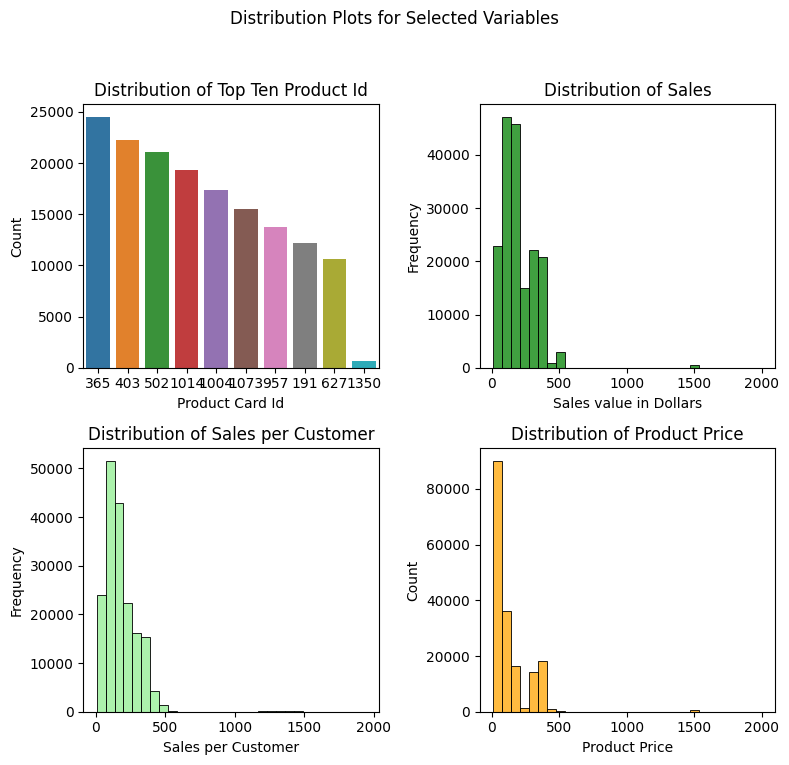

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
fig.suptitle('Distribution Plots for Selected Variables', fontsize=12)

dataset_copy = dataset.copy()

#Top 10 products as per the count
sns.countplot(data=dataset_copy, x='Product Card Id', ax=axes[0, 0], 
                order=dataset_copy['Product Card Id'].value_counts().iloc[:10].index)
axes[0, 0].set_title('Distribution of Top Ten Product Id')
axes[0, 0].set_xlabel('Product Card Id')
axes[0, 0].set_ylabel('Count')

#Sales distribution
sns.histplot(data=dataset_copy, x='Sales', bins=30, color='green', ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Sales')
axes[0, 1].set_xlabel('Sales value in Dollars')
axes[0, 1].set_ylabel('Frequency')

#Sales per customer Distribution
sns.histplot(data=dataset_copy, x='Sales per customer', bins=30, color='lightgreen', ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Sales per Customer')
axes[1, 0].set_xlabel('Sales per Customer')
axes[1, 0].set_ylabel('Frequency')

#Product Price Distribution
sns.histplot(data=dataset_copy, x='Product Price', bins=30, color='orange', ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Product Price')
axes[1, 1].set_xlabel('Product Price')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])

From the visuals, we get to know that:

The Top Selling Product ID is `365` which corresponds to a product name: `Perfect Fitness Perfect Rip Deck` this indicates a fast-moving product.

The distribution of `Sales Value` and `Sales per customer` are both positively skewed with a long tail. This indicates that the majority of sales are for <b>low-value products</b>. This is an interesting insight because it may suggest that the majority of customers are price-sensitive.

The distribution of `Product Price` is also positively skewed with a long tail. This means that the majority of products are low-value products.

<b>NOTE</b>: Based on the insight from the univariate analysis, The rest of the analysis and forecasting will focus on the top-selling Product Card Id (365 ‘Perfect Fitness Perfect Rip Deck’)

### Exploratory Time Series Visualization
To understand the demand patterns of the top-selling product, let's create a time series lineplot to visualize the demand patterns of the top-selling product over time.

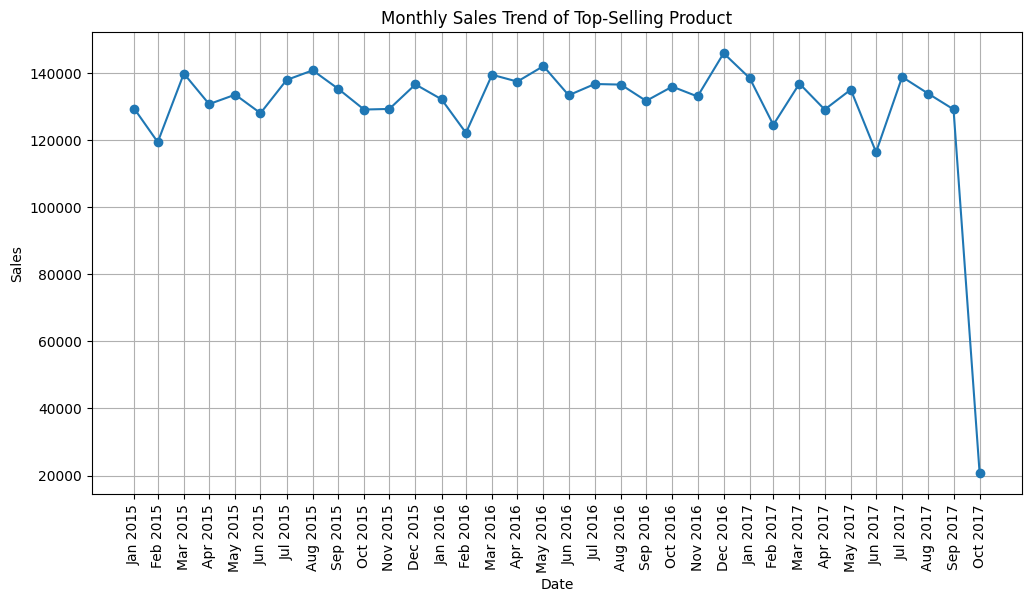

In [17]:
top_product_data = dataset[dataset['Product Card Id'] == 365]
df_lineplot = top_product_data[['shipping date (DateOrders)', 'Sales']]
# Set 'order date (DateOrders)' as index
df_lineplot.set_index('shipping date (DateOrders)', inplace=True)

# Resample to monthly frequency and sum the sales
monthly_sales = df_lineplot.resample('M').sum()

# Plot the time series line plot
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales['Sales'], marker='o', linestyle='-')
plt.title('Monthly Sales Trend of Top-Selling Product')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)

# Format the x-axis tick labels to display month and year
plt.xticks(monthly_sales.index, [x.strftime('%b %Y') for x in monthly_sales.index], rotation=90)
plt.show()

The line plot reveals a consistent trend in the demand for the <u>top-selling product</u> over time. Notably, sales figures for the years `2015` and `2016` remained relatively stable. However, a significant drop in sales is observed in the `July 2017`. Also there were no orders of this product in the years `2018`.
<p>This is an interesting insight that we can explore further.</p>


## ~ Demand Forecasting with Prophet ~

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. Prophet is open source software released by Facebook's Core Data Science team.

The forecasting will focus on the top-selling Product Card Id (365 ‘Perfect Fitness Perfect Rip Deck’).

Let's dive into the process...

In [18]:
prophet_data = top_product_data.copy()
prophet_data = prophet_data.rename(columns={'shipping date (DateOrders)': 'ds', 'Sales': 'y'})

holidays_df = pd.read_excel('US-PR-holidays.xlsx')
holidays_df = holidays_df.rename(columns={'Date': 'ds',
                                          'Name': 'holiday'})
holidays_df['ds'] = pd.to_datetime(holidays_df['ds'])
holidays_df = holidays_df.drop(columns=['Country', 'Year'])

# Add 'lower_window' and 'upper_window' columns
holidays_df['lower_window'] = 0
holidays_df['upper_window'] = 1

# prophet_data.plot(x='ds', y='y', figsize=(18,6))

In [19]:
prophet_data.shape

(24515, 41)

In [20]:
model = Prophet(holidays=holidays_df)
model.fit(prophet_data)

21:13:00 - cmdstanpy - INFO - Chain [1] start processing
21:13:08 - cmdstanpy - INFO - Chain [1] done processing


In [21]:
#DataFrame with future dates for forecasting
future_dates = model.make_future_dataframe(periods=730, freq='D')
forecast = model.predict(future_dates)
forecast.shape

(20843, 88)

In [22]:
forecast.columns 

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Christmas Day', 'Christmas Day_lower', 'Christmas Day_upper',
       'Christmas Day (observed)', 'Christmas Day (observed)_lower',
       'Christmas Day (observed)_upper', 'Columbus Day', 'Columbus Day_lower',
       'Columbus Day_upper', 'Constitution Day', 'Constitution Day_lower',
       'Constitution Day_upper', 'Discovery Day', 'Discovery Day_lower',
       'Discovery Day_upper', 'Discovery Day (observed)',
       'Discovery Day (observed)_lower', 'Discovery Day (observed)_upper',
       'Emancipation Day', 'Emancipation Day_lower', 'Emancipation Day_upper',
       'Emancipation Day (observed)', 'Emancipation Day (observed)_lower',
       'Emancipation Day (observed)_upper', 'Epiphany', 'Epiphany_lower',
       'Epiphany_upper', 'Good Friday', 'Good Friday_lower',
       'Good Friday_upper', 'Independence Day', 'Independence Day_lower',
       'Independence Day_upper', 'Independence Day (observ

The code above uses the Prophet library to model the demand for the top-selling product. The model is trained on the `Sales` and `Shipping Date Columns`. The model is then used to forecast the demand for the top-selling product over the next 730 days.

The code also included holidays of the 2 countries (US, PR) to account for the impact of holidays on the demand for the top-selling product. This is important because holidays can have a significant impact on demand patterns.

The forecast variable now contains the forecasted values for the top-selling product. We will work with it later but for now, let’s first evaluate the accuracy of our prophet model

### Evaluating the Accuracy of the Time Series Forecast

To determine the accuracy of the prophet model, we will use the `cross_validationa()` function provided by `Prophet`

In [23]:
from prophet.diagnostics import cross_validation, performance_metrics

In [24]:
cv = cross_validation(model=model, initial='365 days', period='365 days', horizon='365 days')

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/1 [00:00<?, ?it/s]

21:17:30 - cmdstanpy - INFO - Chain [1] start processing
21:17:33 - cmdstanpy - INFO - Chain [1] done processing


The `cross_validation()` function performs cross-validation on the model. It trains the model on a subset of the data and then evaluates the model on the remaining data. This is a good way to evaluate the accuracy of the model.

The `initial` parameter specifies the size of the training set i.e. the model will be trained on the data from the first 365 days. 

The `period` parameter specifies the frequency of the forecast i.e.  a new evaluation window will start every 365 days. 

The `horizon` parameter sets the forecast horizon for each evaluation period. Here, it's specified as 365 days, meaning the model will make forecasts for the next 365 days in each evaluation period.

Let’s visualize the performance of the model. The `performance_metrics` function in the Prophet library calculates the below metrics for the cross-validated forecasts:

- `MSE`: Mean Square Error
- `RMSE`: Root Mean Square Error
- `MAE`: Mean Absolute Error
- `MAPE`: Mean Absolute Percentage Error
- `MDAPE`: Median Absolute Percentage Error
- `SMAPE`: Symmetric mean absolute percentage error

In [25]:
pm = performance_metrics(cv, rolling_window=0)

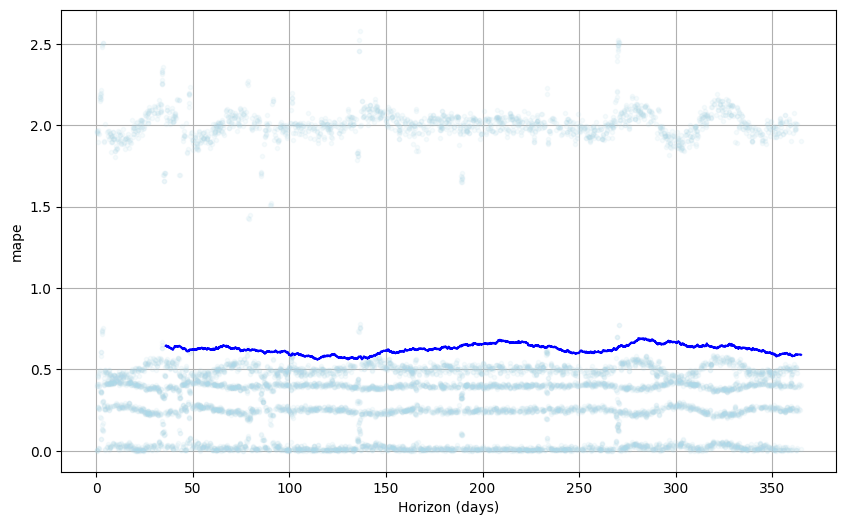

In [26]:
from prophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(cv, metric='mape');
fig.get_axes()[0].get_lines()[0].set_markerfacecolor('#ADD8E7')  
fig.get_axes()[0].get_lines()[0].set_markeredgecolor('#ADD8E7')

Here, we will consider only `MAPE`, because, it provides a clear understanding of the accuracy of the predictions in percentage terms, making it interpretable and comparable across different forecasting models. Also, taking the mean of these MAPE values will provide an aggregate measure of model performance across all iterations, giving a single representative value.

The forecast has relatively constant `MAPE` (Mean Absolute Percentage Error) values for horizons within the 365-day range.

Exposing the model to more historical data may help lower the MAPE significantly. Moreover, let’s explore if there are opportunities to improve the accuracy by finding the best combinations of hyperparameters for the prophet model. I will use a hyperparameter tuning technique to try to optimize the model’s performance.

Let's do this...

### Hyperparameter tuning for improve model accuracy

In [ ]:
from sklearn.model_selection import ParameterGrid

In [ ]:
prophet_data = dataset.copy()
prophet_data = prophet_data.rename(columns={'order date (DateOrders)': 'ds',
                                            'Sales': 'y'})


In [ ]:
# Specify hyperparameter values to try
param_grid = {
    'seasonality_mode': ["additive", 'multiplicative'],
    'seasonality_prior_scale': [0.1, 0.5, 1, 5, 10],
    'holidays_prior_scale': [1, 2, 5, 10, 15],
    'changepoint_prior_scale': [0.005, 0.001, 0.01, 0.05, 0.1]
}

# Generate all combinations of hyperparameters using ParameterGrid
param_combinations = ParameterGrid(param_grid)

The code above uses the `ParameterGrid` function from the `sklearn` library to create a grid of hyperparameters. The grid contains different combinations of hyperparameters for the prophet model.

On the other hand, the code below uses the `cross_validation()` function to evaluate the accuracy of the model for each combination of hyperparameters. The code then selects the combination of hyperparameters that results in the <i>lowest MAPE</i>.

Here, we will consider only MAPE, because, it provides a clear understanding of the accuracy of the predictions in percentage terms, making it interpretable and comparable across different forecasting models. Also, taking the mean of these MAPE values will provide an aggregate measure of model performance across all iterations, giving a single representative value.

<b>NOTE</b>: The code will take a long time to complete. It will try <b>250</b> different combinations of hyperparameters and the best model will be with the one with the lowest MAPE value.

In [ ]:
# To compute the Cartesian product of input iterables.
from itertools import product

In [ ]:
results = {}
print(f"Trying all {len(param_combinations)} hyperparameter combinations")

# Generate all combinations of hyperparameters (This creates a list of tuples, where each tuple represents a unique combination of hyperparameters.)
param_combinations = list(product(*param_grid.values()))

for i in param_combinations:
    #Prophet instance with current parameter combination
    p = Prophet(**dict(zip(param_grid.keys(), i)))
    
    #Fit the model
    p.fit(prophet_data)
    
    #Cross Validation
    cv = cross_validation(model=p, initial='365 days', period='365 days', horizon='365 days')
    
    #Performance metrics
    per_metrics = performance_metrics(cv, rolling_window=0)

    #Store metrics in the results dictionary
    results[i] = per_metrics['mape'].mean()

The hyperparameter tuning took 2 hrs to complete.

In [ ]:
results

In [ ]:
#Hyperparameters with the lowest MAPE
best_hyperparams = min(results, key=results.get)
print(f"Best Hyperparameters: {dict(zip(param_grid.keys(), best_hyperparams))}")

<p>Below are the best parameters:</p>
<b>Best Hyperparameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 5, 'holidays_prior_scale': 1, 'changepoint_prior_scale': 0.1}</b>

Now let’s rebuild the model with the best hyperparameters and evaluate the model’s performance.

In [27]:
tuned_model = Prophet(holidays=holidays_df,
                      seasonality_mode= 'additive',
                      seasonality_prior_scale=5,
                      holidays_prior_scale=1,
                      changepoint_prior_scale=0.95)

#Fit the model
tuned_model.fit(prophet_data)

#DataFrame with future dates for forecasting
future = tuned_model.make_future_dataframe(periods=730, freq='D')

# Generate forecasts
new_forecast = tuned_model.predict(future)

21:19:30 - cmdstanpy - INFO - Chain [1] start processing
21:19:36 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
#Preform Cross Validation
tuned_cv = cross_validation(model=tuned_model, initial='365 days', period='365 days', horizon='365 days')

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/1 [00:00<?, ?it/s]

21:19:58 - cmdstanpy - INFO - Chain [1] start processing
21:20:02 - cmdstanpy - INFO - Chain [1] done processing


Lets compare the accuracy of model before and after hyperparameter tuning

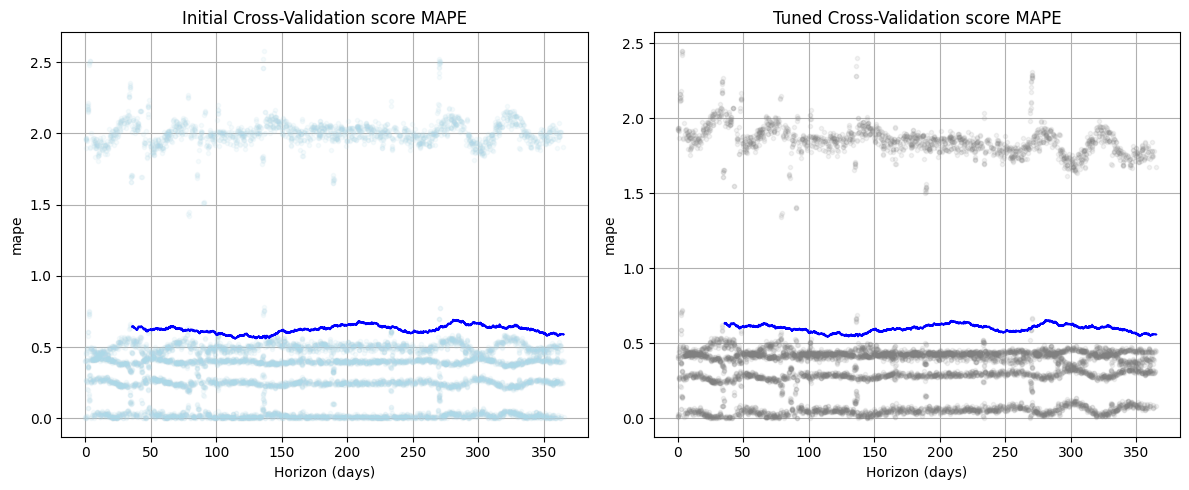

In [29]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot for the first cross-validation metric (before hyperparameter tuning)
fig1 = plot_cross_validation_metric(cv, metric='mape', ax=axs[0])
fig1.get_axes()[0].get_lines()[0].set_markerfacecolor('#ADD8E7')  # Change color of the dots
fig1.get_axes()[0].get_lines()[0].set_markeredgecolor('#ADD8E7')  # Change color of the dot edges
# add title
axs[0].set_title('Initial Cross-Validation score MAPE')

# Plot for the second cross-validation metric (after hyperparameter tuning)
fig2 = plot_cross_validation_metric(tuned_cv, metric='mape', ax=axs[1])
fig2.get_axes()[1].get_lines()[1].set_markerfacecolor('#ADD8E7')  # Change color of the dots
fig2.get_axes()[1].get_lines()[1].set_markeredgecolor('#ADD8E7')  # Change color of the dot edges
# add title
axs[1].set_title('Tuned Cross-Validation score MAPE')

plt.tight_layout()
plt.show()

We can see that the `MAPE` values does not have any changes than the initial model. I also tried different combinations manually to see if the result changes. But it remained the same. From this we can say that the model is not sensitive to the hyperparameters. The model can still be used for forecasting demand for the top-selling product.

### Forecast results 

The `new_forecast` variable contains the forecasted values of our `Sales` time series. Based on this forecast we will calculate the optimal inventory policy for this specific product.

The new_forecast variable is a dataframe that contains the following columns:

In [30]:
new_forecast.columns 

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Christmas Day', 'Christmas Day_lower', 'Christmas Day_upper',
       'Christmas Day (observed)', 'Christmas Day (observed)_lower',
       'Christmas Day (observed)_upper', 'Columbus Day', 'Columbus Day_lower',
       'Columbus Day_upper', 'Constitution Day', 'Constitution Day_lower',
       'Constitution Day_upper', 'Discovery Day', 'Discovery Day_lower',
       'Discovery Day_upper', 'Discovery Day (observed)',
       'Discovery Day (observed)_lower', 'Discovery Day (observed)_upper',
       'Emancipation Day', 'Emancipation Day_lower', 'Emancipation Day_upper',
       'Emancipation Day (observed)', 'Emancipation Day (observed)_lower',
       'Emancipation Day (observed)_upper', 'Epiphany', 'Epiphany_lower',
       'Epiphany_upper', 'Good Friday', 'Good Friday_lower',
       'Good Friday_upper', 'Independence Day', 'Independence Day_lower',
       'Independence Day_upper', 'Independence Day (observ

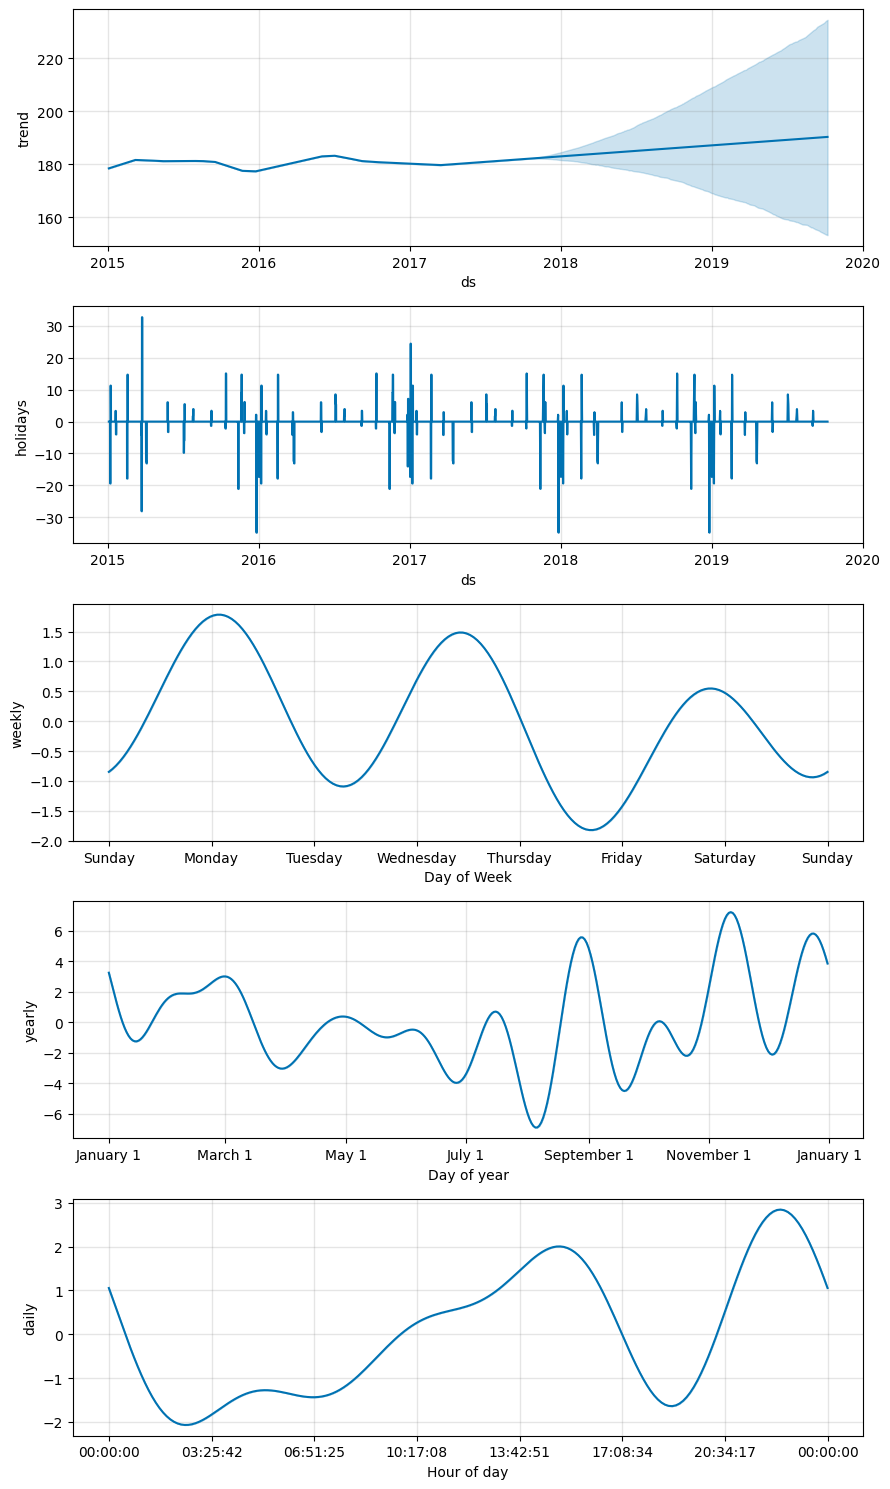

In [31]:
# Visualizing Forecasted Sales
tuned_model.plot_components(new_forecast);

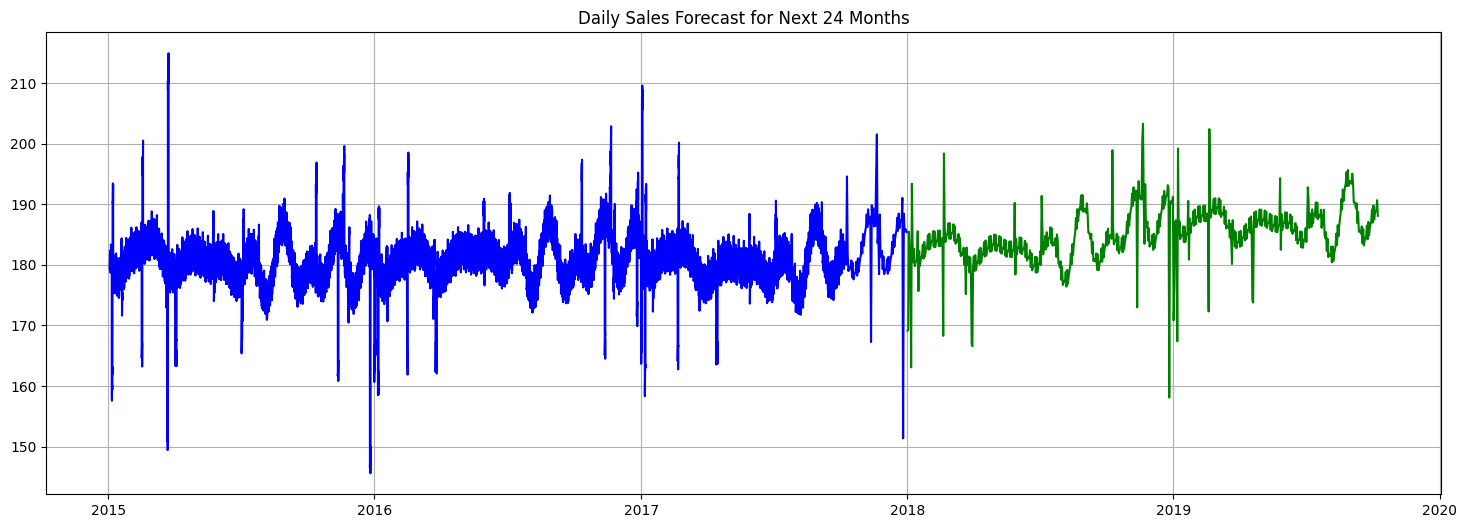

In [32]:
plt.figure(figsize=(18, 6))
# Plot the forecast before 2018 in blue
plt.plot(new_forecast[new_forecast['ds'] < '2018-01-01']['ds'], new_forecast[new_forecast['ds'] < '2018-01-01']['yhat'], linestyle='-', color='blue')
# Plot the forecast after 2018 in red
plt.plot(new_forecast[new_forecast['ds'] >= '2018-01-01']['ds'], new_forecast[new_forecast['ds'] >= '2018-01-01']['yhat'], linestyle='-', color='green')

# plt.xlabel('Date')
# plt.ylabel('Sales')
plt.title('Daily Sales Forecast for Next 24 Months')
plt.grid(True)
# plt.legend()
plt.show()

Lets answer the below question:
#### <i>What is the demand forecast for the top selling product in the next 24 months?</i>


- The sales trend between 2015 and 2017 marks a cycle where sales for the product remained fluctuating all the time with a sharp increase between September and December.

- The forecasted sales for the next 24 months, on the other hand, indicate a stable increasing demand pattern.

- The minimun variance observed in the product price may account for the relatively stable sales pattern forecasted for `2018` and `2019`. It might also be worth investigating the factors that may account for the fluctuations between 2015 and 2017

- We can also observe the impact of the US and Puerto Rican holidays on the forecasted sales.

#### <i>What is the optimal inventory level for the top selling product?</i>
- Lets find out !!

## ~ Finding Optimal Inventory Policy Based on Forecasted Demand ~

Now that we have forecasted the demand for the top-selling product, we can use the forecasted demand to calculate the optimal inventory policy for the product.

Finding the optimal inventory policy will help us determine the `Reorder Point`, `Safety stock`, and `Economic Order Quantity(EOQ)` for the product. These markers will help us ensure that we have the right amount of inventory on hand to meet customer demand while minimizing inventory costs.

### `Reorder Point (ROP)` - 
A reorder point (ROP) is a specific level at which your stock needs to be replenished. In other words, it tells you when to place an order so you won’t run out of stock.  Setting a reorder point helps you optimize your inventory, replenish your stock of individual items at the right time, and meet your market demand without going out of stock.

To calculate ROP, we need:
- **Average sales per day**: How much of this item are you selling every day? 

- **Lead time**:  The Lead Time with regards to the ROP is the time it takes for a product to be delivered by <u>upstream</u> supply chain manufacturers to the store's warehouse i.e. It is the time taken (in days) for your vendor to fulfill your order. The current dataset only provides the `Days for shipment (scheduled)` and the `Days for shipping (real)` which only helps us determine downstream lead times. The <u>downstream</u> lead time is the time it takes for a product to be delivered to the customer after it has been ordered. This is not the lead time we need to calculate the reorder point. So for the purposes of our analysis we will assume an **average upstream `Lead time` of <i>6 days.</i>**

- **Safety stock**: The amount of extra stock,, that you would keep in your inventory to help avoid stockouts due to uncertainties in demand and lead time.

The formula for ROP is:
-            Reorder point = lead time demand + safety stock

where the Lead Time Demand is calculated as:
-            Lead Time Demand = average sales per day * lead time

and the safety stock is calculated as:
-            Safety stock = (maximum daily sales * maximum lead time) – lead time demand 

As explained above, lets also assume that there have been delays from the manufacturer in the past and the maximum lead time is 10 days i.e 4 days later than the average order fulfillment timeline.

<i><b>Note</b>: All this is been done for the top selling product (by order frequency) i.e Perfect Fitness Perfect Rip Deck</i>
             
Lets calculate !!

In [33]:
# CALCULATING LEAD TIME DEMAND

# average forecasted sales
avg_daily_forecasted_sales = new_forecast['yhat'].mean().round(3)
print(f"Average Daily Forecasted Sales: {avg_daily_forecasted_sales}")

# assumed average lead time (in days)
avg_lead_time = 6
print(f"Average Lead Time: {avg_lead_time}")

# lead time demand
lead_time_demand = avg_daily_forecasted_sales * avg_lead_time
print(f"Lead Time Demand: {lead_time_demand}")

Average Daily Forecasted Sales: 180.507
Average Lead Time: 6
Lead Time Demand: 1083.042


In [34]:
# CALCULATING SAFETY STOCK

# maximum daily sales
max_daily_forecasted_sales = new_forecast['yhat'].max().round(3)
print(f"maximum Daily Forecasted Sales: {max_daily_forecasted_sales}")

# assumed max lead time (in days)
max_lead_time = 10
print(f"Average Lead Time: {max_lead_time}")

safety_stock = (max_daily_forecasted_sales * max_lead_time) - lead_time_demand
print(f"Safety Stock: {safety_stock.round(3)}")

maximum Daily Forecasted Sales: 214.908
Average Lead Time: 10
Safety Stock: 1066.038


Thus, now we have `Lead Time Demand` and `Safet Stock`. So we can now find the `Reorder Point (ROP)`:

In [35]:
# CALCULATING ROP
rop = lead_time_demand + safety_stock
print(f"The Optimal Reorder Point for the Top-selling Product is: {rop}")

The Optimal Reorder Point for the Top-selling Product is: 2149.08


The observed outcome suggests that the optimal reorder point for our highest-selling product (Perfect Fitness Perfect Rip Deck) is `2149` units. This suggests that when we have only `2149` units left in stock, we should initiate restocking procedures to make sure we always have enough for customers. Maintaining stock above this quantity ensures sufficient supply to meet customer demand while also optimizing inventory management costs.

### `Economic Order Quantity (EOQ)` - 

Economic order quantity (EOQ) model is another method to determine the optimal order quantity / inventory reorder point. It is the ideal quantity of units a company should purchase to meet demand while minimizing inventory costs such as holding costs, shortage costs, and order costs. The economic order quantity formula assumes that demand, ordering, and holding costs all remain constant. Assuming demand for the products as constant sometimes results as one of the limitations of this method. This method helps make efficient inventory management decisions.

Unlike the Reorder Point which is concerned with determining the level of inventory at which a new order should be placed to avoid stockouts, EOQ takes into account the costs of ordering (e.g., setup costs) and the costs of holding inventory (e.g., storage costs, opportunity costs).

The Economic Order Quantity (EOQ) formula is given by:

$ EOQ = \sqrt{\frac{2DS}{H}} $

where:
- Q: EOQ units
- D: Demand in units,
- S: Ordering cost per order,
- H: Holding cost per unit per year.

Economic order quantity (EOQ) will be higher if the ordering costs or product demand increases. On the other hand, it will be lower if the company’s holding costs increase.

Ordering Cost: 

<b>NOTE</b>: We can figure out the demand rate ( D ) based on the existing data. However, the ordering cost ( S ) and holding cost ( H ) are not provided in the dataset. For our analysis, We will assume that the ordering and holding cost is 10% and 25% of the product price respectively.

In [36]:
# product price
product_price = top_product_data['Product Price'].iloc[0]
print(f"The Product Price is: {product_price}")

# calculate holding cost
H = 0.10 * product_price
print(f"The Holding Cost is: {H}")

# calculate ordering cost
S = 0.25 * product_price
print(f"The Ordering Cost is: {S}")

# calculate forecasted demand rate
D = new_forecast['yhat'].mean()
print(f"The Demand Rate is: {D}")

The Product Price is: 59.99000168
The Holding Cost is: 5.999000168
The Ordering Cost is: 14.99750042
The Demand Rate is: 180.5070486119946


Thus, now we have `H`, `S` and `D`. So we can calculate Economic Order Quantity (EOQ) as:

In [37]:
EOQ = math.sqrt((2 * D * S) / H)
print(f"The Economic Order Quantity is: {EOQ}")

The Economic Order Quantity is: 30.042224336090243


Hence, according to the EOQ model, the optimal order quantity for the top-selling product is `30` units. This means that we should order `30` units of the product at a time to minimize the total inventory costs. This will help us ensure that we have the right amount of inventory on hand to meet customer demand while minimizing inventory costs.

So here's the answer the second question i.e.
#### <i>What is the optimal inventory level for the top selling product?</i>

The optimal inventory policy for the top-selling product is as follows:
- **Reorder point**: 2149 Units
- **Safety stock**: 1066 Units
- **Economic Order Quantity**: 30 Units

Thus, when the stock level of the top-selling product hits 2149 units, it's time to order 30 more units from the supplier to keep up with demand and maintain sufficient stock levels. Also, a safety stock of 1066 units should be kept in inventory to avoid stockouts.

Using these strategies for inventory management will help the company keep enough of the best-selling product in stock to meet customer needs while keeping costs low.

## SUMMARIZING THE KEY TAKEAWAYS:

The project focused on forecasting the demand and managing inventory for the best selling product according to the order frequency.

- We explored how to build a demand forecasting model with Python and evaluate its performance.
- We discovered trends, seasonalities and holiday effects on the top-selling product based on the dataset provided.
- We used the model for inventory optimization, covering concepts like reorder points, safety stock, and economic order quantity (EOQ).
- We found the optimal inventory policy for the top-selling product.